# Interferometer arm noise
In this IFSharp notebook I am going to simulate the noise that appears on the interferometer arm. The idea is to follow *Vinet et.al.* article called *Scattered light noise in gavitational wave interferometric detectors: A statistical approach*.  
<img src="img/GWInterferometer.jpg" width=400 height=400/>
Even if this is not going to be the good version, I want to prove that the method I have developed based on the paper works and gives some similar result to the obtained on the paper for the interferometer noise, even if it cannot be compared. I say that because they implement directly $n(f)$ of the tube noise instead of implementing $X(t)$. This makes that there's missing information that I don't know, like the amplitude of the tube vibration. But, in any case the best solution should be:
 100. $A \ll\lambda/2 $ and thus there's no upconversion.
 9. Case where the amplitude of the vibration is bigger than the wavelenght

<img src="img/vibratingWall.jpg" width=400 height=400/>

Also there are more points that will be different between my simulation and the original ones, so I need to be careful when I decide to compare both results.

##### Always the first thing that must be done is to reference the libraries and open them


In [4]:
// test on forward ray tacing
#r @"..\Types\bin\Debug\Types.dll"
#r @"..\RayTracing\bin\Debug\RayTracing.dll"
#r @"..\PostProcess\bin\Debug\PostProcess.dll"
//Math.Net
#r @"..\packages\MathNet.Numerics.3.11.1\lib\net40\MathNet.Numerics.dll"
#r @"..\packages\MathNet.Numerics.FSharp.3.11.1\lib\net40\MathNet.Numerics.FSharp.dll"

// libraries referenced
open Types.Algebra
open Types.ObjectTypes
open Types.types
open RayTracing.intersections
open Microsoft.FSharp.Data.UnitSystems.SI.UnitSymbols
open ForwardRayTracing
open SaveSensorInfo
open Random
open System.IO
open MathNet.Numerics.IntegralTransforms
open System.Numerics
open PostProcess.Noise
open periodogram

##### And the set up is:

**Tube**:  
$R_{tube} =  0.6m $  
$L_{tube} = 3\cdot 10^3 m$    
$BRDF = 1/2\pi$ ??

**Mirrors**:  
$R_{mirror} =  0.175m$ ($0.170m$ with coating)  
$b(\theta) = k/\theta^2$ (and $K \sim 0.09936$ with $\theta_{min} = 55\cdot10^{-6}$)  **Later will be explained** 
$\epsilon \sim 10^{-6}$  
Even if they are not directly used, the RoC are:  
$RoC_{Input]}=  1420 m$  
$RoC_{End} =  1683 m $  
This information of radius with the Length of the cavity shows that we have a **Near concentric** cavity.

**About the cavity**:  
$P_{stored} = 0.8 MW$ (*Aproximately*)  

**Ray & Beam**:  
Number of Rays = ?
$\lambda = 1.064\cdot 10^{-6} m$  
$\sigma = 0.028 m $ (waist) obtained considering that 
$$\omega_{1} \approx \omega_{2} \approx \dfrac{L\lambda}{\pi} \sqrt{\dfrac{4 L}{\Delta L}}$$

which becomes in program values of:

In [26]:
let Rtube, Ltube = 0.6<m>, 3e3<m>
let Rmirror = 0.175<m>

let wavelength = WaveLength(1.064e-6<m>)
let BeamWaist = 0.028<m>
let Nrays = 50000


To define the objects, the mirrors will be defined as 2 discs each one with the measure of the mirror and the tube will be a cylinder.  
*I will consider the convention that says that the zero position is the mirror closer to the Beam Splitter* (even if here it doesn't exit).
##### Mirrors and Tube

In [27]:
// Define the cylinder
let t , Amplitude = [|(0.)..(1./400.)..6.|], Vector(0.,0.,3.e-6)   // Temporal series for the phase scan
let Amplitude_big =  Vector(0.,0.,2e-6)
let noise = ([|(10uy,Amplitude,0.)|] , t)    // (f,) 
let noise_upconversion = ([|(10uy,Amplitude_big,0.)|], t)
let tube = cylinder(Rtube,Ltube,Point(0.,0.,0.),UnitVector(1.,0.,0.),"Tube", Sensor(), noise_upconversion)

// define the mirrors
let m1 = disc(Point(0.,0.,0.), float Rmirror, UnitVector(1.,0.,0.),"Mirror") 
let m2 = disc(Point(float Ltube,0.,0.), float Rmirror, UnitVector(-1.,0.,0.),"Mirror", true)
let objs = [|Cylinder(tube); Disc(m1);Disc(m2)|]

In [28]:
tube.Sensor.Exists |> Display

false

### How the rays interact with the tube?  
Here I define the materials that should be 2:
  - Mirror: Dummy
  - Tube: Steel/ stainless steel
  
Future updates of this notebook should include the addition of other materials like *Black absorving gas* for the baffles.  
Another important point that I haven't considered well on my code is how to deal with a material that changes its properties with the angle of incidence, a real BRDF.

<img src="img/Stainless steel.jpg" width=400 height=400/>


In [29]:
let mout = [|{MatName= "Mirror"; R=1.; T=0.;
                 n=(2.,WaveLength(1.06e-6 |> LanguagePrimitives.FloatWithMeasure<m>));LambPPM= 1e-6};
             {MatName= "Tube"; R=0.95; T=0.0; 
                 n=(1.3,WaveLength(1.06e-6 |> LanguagePrimitives.FloatWithMeasure<m>));LambPPM= 0.05};
             {MatName= "air"; R=0.; T=1.; 
                 n=(1.,WaveLength(1.06e-6 |> LanguagePrimitives.FloatWithMeasure<m>));LambPPM= 0.}
             |]

let mat = dict (mout|> Array.map(fun x -> (x.MatName,x)))

### How rays are generated?

Rays should follow a gaussian distribution with a diameter $\sigma$ based on the beam diameter at the mirror position ($2.8cm$) and with the direction based on it's $b(\theta) = k/\theta$ for a $ \pi/2 \geq\theta \geq \theta_{min}$.  
From this work, I still need to discover how I can generate a random variable $\Theta$ which follows the previously specified pdf. This function has been defined as inv_sqr() on the *Random module* inside *Types* project.
#### Generate the Random Angle
To generate the random angle, it must be computed following the next method:
$$ \int_{\theta_{min}}^{\theta_{max}} b(\theta) sin(\theta) d\theta  = 1$$
and 
$$ \int_{\theta_{min}}^{\Theta} b(\theta) sin(\theta) d\theta  = X$$
Since the resultant integral cannot be directly computed since it's depends on $\Gamma$ function, I have decided that a Taylor approximation of the result can be considered good using a Taylor expasion for $sin(x)$ up to order 7. This results in:
$$k \Big[  ln(\theta)-\dfrac{\theta^3}{2\cdot 3!} +\dfrac{\theta^5}{4\cdot 5!} - \dfrac{\theta^6}{6\cdot 7!} \Big]_{\theta_{min}}^{\Theta}  = X$$

##### Quick comment why the normalization is $sin\theta d \theta$:
    I must remember that even though the transformation for spherical coordinates is different, the change of variables is not comming from the spherical coordinates, it comes from the solid angle and thus we have: 
 $$d\Omega = sin(\theta) d\theta d\phi $$
    
    which makes that the normalization of b functions must be done with the sin.

Then I need to define $\phi$ which is equally probably on every direction, $\phi = 2\pi X$. This means that once I have the pair $(\theta, \phi)$, I must transform from spherical to cartesian coordinates to define the ray direction. Thus,
$$ \vec {u}_{vec} = (cos(\phi)\cdot sin(\theta), sin(\phi)\cdot sin(\theta), cos(\theta)) \; |> \;ChangeCoordinates$$
$$ Point = RandomGauss\;|>\; ChangeCoordinates$$

To see that the function defined to generate $\theta$ works, I have coded a histogram:

In [39]:
let NewtonRapson (x0:float) (f:float->float) (f1:float->float) (tol:float) (maxIter:int) =   
    let mutable haveWefoundASolution = false
    let epsilon = 1e-14
    let mutable x = x0
    let mutable xprim = 0.
    
    let numitrs =
        [|1..maxIter|] 
        |> Array.tryPick( fun _ -> 
                               let y = f x
                               let yp = f1 x
                               match abs(yp) with
                               | d when d <= epsilon ->
                                   //x <- -infinity
                                   Some(true)
                               | _ ->
                                   let x1 = x - y/yp
                                   if abs(x1-x) <= tol*abs(x1) then haveWefoundASolution <- true
                                   if abs(y) < epsilon then haveWefoundASolution <- true
                                   x <- x1     // update the variable
                                   xprim <- y
                                   match haveWefoundASolution with true -> Some(true) | _ -> None
                      ) 
    (x), (haveWefoundASolution, numitrs)  // return the value + extra information

In [40]:
// un test con NR
let f x = x*x
let f1 x = 2.*x
NewtonRapson 0.85 f f1 (1e-7) (200)

(2.533197403e-08, (true, Some true))

In [52]:
let hist (data:float[]) (nbins:int)=
    // Function to create a histogram
    let ma, mi = (data |> Array.max)+1e-10 , data |> Array.min 
    let wide = (ma-mi)/float(nbins)
    let xaxis = [|1..nbins|] |> Array.map(fun x -> float(x)*wide/2.+mi)
    let out = Array.init nbins (fun _ -> 0.) // initialize the output 
    data 
    |> Seq.iter( fun x -> 
                        let whichbin = int((x-mi)/wide)
                        printfn "%d" whichbin
                        //printfn "%f   %f %f" x mi wide
                        (out.[whichbin] <- out.[whichbin]+1.)
                    )
    let norm = out |> Array.sum  // normalization factor
    (out, xaxis) ||> Array.map2(fun x y -> ( y, (x/norm)))
  

In [62]:
  
let inv_sqr() =
    // Generate a random number based on the 
    // pdf = k/theta^2 with theta € [th_min, pi/2] 
    let xrand = rnd.NextDouble()
    let k =  0.09932750   //0.01006406986 // based on the current thmin = 10^-2
    let tho = 55e-6
    let tol, maxIter = 1e-7, 1000
    (*
    let thmin= 55e-6//  old and wrong 1e-2
    
    k*thmin/(k-thmin*r) *)
    let f0  (th:float) (th0:float) (x:float) = // function
        k*(log(th/th0)-((th**2.)-(th0**2.))/(12.)+((th**5.)-(th0**5.))/(480.)-((th**7.)-(th0**7.))/(30240.)) - x
    let f1 th =    // derivate
        k*((1./th)-th/6.+(th**3.)/120.-(th**5.)/5040.) 
    let f th = f0 th tho xrand  
    // there's a problem with the x0 point, if it's now the th_min it raises an error
    fst (NewtonRapson (0.000055) f f1 tol maxIter)  
  
        
        
let test = [|0..10000|] |> Array.map(fun _ -> inv_sqr())
//let htest = hist test 100


//let r = rnd.NextDouble()

In [63]:
let htest = hist test 100


5.5e-05

In [17]:
let k =  0.09932750 // based on the current thmin = 10^-2
let thmin = 55e-6
let nmax = 50
let pdf = [|0..nmax-1|] 
          |> Array.map(fun x -> let thdif = ((PI/2.-thmin)/float nmax)
                                let th = (thdif*(float x))+thmin
                                th,(k/th/th)*sin(th)
                                
                       )
          // |> Array.sum


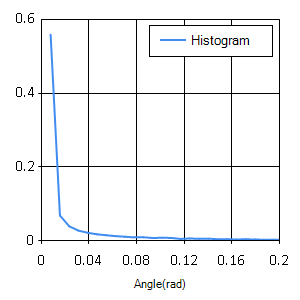

In [65]:
Chart.Combine([ Chart.Line(htest, Name="Histogram")]) //;Chart.Line(pdf, Name="pdf")])
|> Chart.WithXAxis(Min=0.,Max=0.2, Title="Angle(rad)")
|> Chart.WithLegend()
|> Chart.WithSize(300, 300)//|> Display

remember, **Nrays** is the value used to define the number of rays that will be traced.  

Thus, the rays for this configuration are generated as:

In [10]:
let NewRay (pos:Point) (normal:UnitVector) (sigma:float) (rMax:float) =
    let rotpoint = Matrix.RotateVector(UnitVector(0.,0.,1.),normal)
    let rec rfPos() =  // position function
        let orig = Samp2DGauss(sigma,0.) |> fun x -> Point(x.[0],x.[1],0.)
        if orig.ToVector().Module() > rMax then rfPos()
        else
            let rp = rotpoint.RotatePoint(orig)
            rp |> fun px -> px.MoveAndCreateNew(pos) 
    let rPos = rfPos()
    let rvect = // direction
        let theta = inv_sqr()
        let phi = 2.*PI*rnd.NextDouble()
        let stheta = sin(theta)
        UnitVector(cos(phi)*stheta, sin(phi)*stheta, cos(theta))
        |> fun x -> rotpoint.RotateVector(x)
    {
         Wavelenght = wavelength;
         from = rPos; uvec = rvect;
         MaxLength = infi;
         OpticalPathTravelled = 0.<m>;
         NumBounces = 0uy; bounces = [];
         MaxDispersions = 3uy;
         NumOfParticles = 1;
         IndexOfRefraction = 1.
         PhaseModulation = [||]
    }
let ps0 = Point(0.,0.,0.)
let dir0 = UnitVector(1.,0.,0.)

// Function to generate the rays
let ray() = NewRay ps0 dir0 (float(BeamWaist)) (float(Rmirror))

In [30]:
let r = ray()
(r.uvec.X,r.uvec.Y,r.uvec.Z)

(0.9999499176, 0.001769729703, 0.009850402598)

In [31]:
[|1..Nrays|] |> Array.Parallel.iter(fun x -> ForwardRay(ray(),objs,mat) ) // ok, look like works

<null>

In [32]:
m2.Sensor.SavedData.[0].Noise.Length, m2.Sensor.SavedData.Length

(2401, 259)

In [8]:

let path_save1 = @"C:\Users\Jose M. Gonzalez\Desktop\Vibration1_Save_Phase.txt"
SumAndSavePhases (m2.Sensor) (m2.Normal) (path_save1)

System.IndexOutOfRangeException: Index was outside the bounds of the array.
   at PostProcess.Noise.SumAndSavePhases(Sensor snrs, UnitVector mrNormal, String path_save) in C:\Users\Jose M. Gonzalez\OneDrive\Phd\render\ray casting\Sample parts for version 2\Library1\PostProcess\Noise.fs:line 87
   at <StartupCode$FSI_0010>.$FSI_0010.main@() in C:\Users\Jose M. Gonzalez\OneDrive\Phd\render\ray casting\Sample parts for version 2\Library1\notebooks\input.fsx:line 2
Stopped due to error

### Analysis of the results
To be able to analize the noise on the output, I have the PostProcess library which producess the noise spectrum of the output.


## Some comments about the PSD and how to compute it:
from [Matlab's manual on signal processing](http://it.mathworks.com/help/signal/ug/psd-estimate-using-fft.html) we can find that:
$$ PSD = \dfrac{1}{f_{sampling}\cdot N} |fft(x)|^2 $$
Where $f_{sampling} means for the maximum sampling frequency which is 2 times the maximum obtained on the fft. Also there's the point that since we only use the positive frequencies, then we multiply the obtained PSD per 2 in order to obtain show all on the positive axis.

Another method to compute the PSD is to use one of the signal analysis functions available on *scipy* which already compute the PSD. One of those methods are [welch](http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html#scipy.signal.welch) which applies a [window function](https://en.wikipedia.org/wiki/Window_function) and by default has the hanning

In [33]:
let planckConstant, vLight = 6.626070e-34, 299792458. 
let wavelen = (match ray().Wavelenght with WaveLength x -> float x)
let PhotonEnergy = planckConstant*vLight/wavelen
let pp = 0.8e6

1./(1e-6*pp/PhotonEnergy)

2.333700437e-19

Original method in which I was computing the FFT withouth periodogram

In [36]:
let phnoise = NoiseInterferometerArm_WELCH m2 tube mat (ray()) 8e5 Nrays 300// transform the phase into noise


System.AggregateException: One or more errors occurred. ---> System.ArgumentException: The arrays have different lengths.
Parameter name: array2
   at Microsoft.FSharp.Collections.ArrayModule.Map2[T1,T2,TResult](FSharpFunc`2 mapping, T1[] array1, T2[] array2)
   at periodogram.welch_method@22.Invoke(Int32 i) in C:\Users\Jose M. Gonzalez\OneDrive\Phd\render\ray casting\Sample parts for version 2\Library1\PostProcess\periodogram.fs:line 23
   at System.Threading.Tasks.Parallel.<>c__DisplayClass17_0`1.<ForWorker>b__1()
   at System.Threading.Tasks.Task.InnerInvokeWithArg(Task childTask)
   at System.Threading.Tasks.Task.<>c__DisplayClass176_0.<ExecuteSelfReplicating>b__0(Object )
   --- End of inner exception stack trace ---
   at System.Threading.Tasks.Task.ThrowIfExceptional(Boolean includeTaskCanceledExceptions)
   at System.Threading.Tasks.Task.Wait(Int32 millisecondsTimeout, CancellationToken cancellationToken)
   at System.Threading.Tasks.Parallel.ForWorker[TLocal](Int32 fromInclusi

In [24]:
let path_save = @"C:\Users\Jose M. Gonzalez\Desktop\Vibration1_all_upconversion.txt"
let path_savef = @"C:\Users\Jose M. Gonzalez\Desktop\Vibration1_all_upconversion_freqs.txt"

//File.WriteAllLines( path_save, (snd phnoise) |> Array.map(fun x -> string(x)) );;
File.WriteAllLines( path_savef, (fst phnoise) |> Array.map(fun x -> string(x)) );;
//fst phnoise

<null>

**Periodogram**

In [32]:
let ph = m2.Sensor.SavedData.[1].Noise //|> Array.map(fun c -> (c)) // :? Array - string

let psd = PSD_WELCH(t,ph|> Array.map(fun x -> sin(x))," ",256,0,0.)

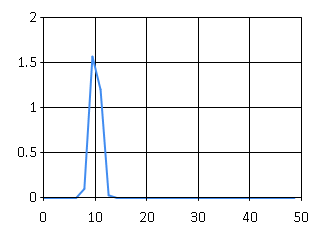

In [33]:
(fst psd).Length, (snd psd).Length
Chart.Line(psd ||> Array.map2(fun x y -> (x,y)))
|> Chart.WithXAxis(Min= 0., Max = 50.)

### Baffle design

The baffle design on the arm cavities are disseminated on many articles. Including the Technnical desing of Advance virgo and other notes  [Summary of scattered light noise calculations and baffle design in the long cavities](https://tds.ego-gw.it/itf/tds/index.php?callContent=2&callCode=721) available on Virgo TDS.

<img src="img/baffle_design.png" width=400 height=400/>
